# Introduction

This notebook includes all of the code used for a presentation on gammatone filters for MUMT 618, Nov 18 2020.

In [ ]:
# Imports 

import numpy as np
import matplotlib.pyplot as plt
import math

### Self Normalizing Two-Pole Class

In [ ]:
SAMPLE_RATE = 44100
DPI = 150

# Simple resonating filter. Tune with f0.

class TwoPoleDC:
    """
    Two-pole filter parameterized such that DC gain is unity.

    a1, a2 (float32)    :   Autoregressive filter coefficients.

    With apologies to:
        R. F. Lyon, Human and Machine Hearing: Extracting Meaning from Sound, 
        1st ed. Cambridge University Press, 2017.

    Max Henry, Nov 15 2020. 8:38pm.
    """
    def __init__(self, a1, a2):
        self.a1 = a1
        self.a2 = a2
        self.yn1, self.yn2 = 0, 0

    def __call__(self, in_):
        out_ = in_ - self.a1 * (self.yn1 - in_) - self.a2 * (self.yn2 - in_)
        self.yn2 = self.yn1
        self.yn1 = out_
        return out_

class TwoPole:
    """
    Two-pole filter without normalization, included for comparison purposes.

    a1, a2 (float32)    :   Autoregressive filter coefficients.
    """
    def __init__(self, a1, a2):
        self.a1 = a1
        self.a2 = a2
        self.yn1, self.yn2 = 0, 0

    def __call__(self, in_):
        out_ = in_ - self.a1 * self.yn1 - self.a2 * self.yn2
        self.yn2 = self.yn1
        self.yn1 = out_
        return out_

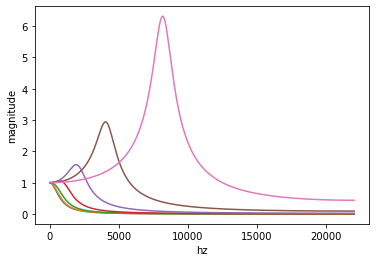

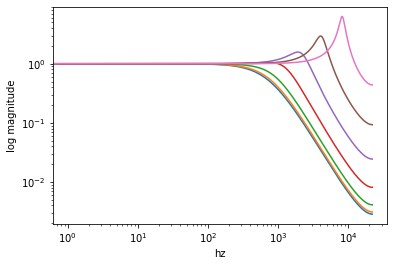

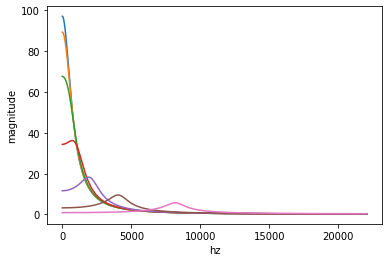

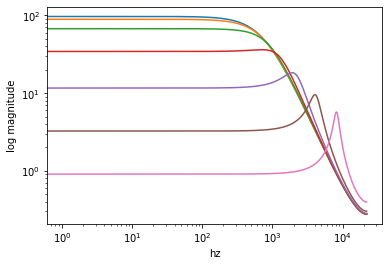

In [ ]:
# Example implementation, with plots.

N = 44100
hN = int(N//2)
freqs = np.linspace(0, SAMPLE_RATE/2, hN)

x = np.zeros(N)
x[0] = 1

unity_ffts = []
nonunity_ffts = []

f0s = np.array([128, 256, 512, 1024, 2048, 4096, 8192])

def unity_nonunity_graphs(f0s):
    for f0 in f0s:
        R = 0.9
        T = 1/SAMPLE_RATE

        a1 = -2 * R * np.cos(2 * np.pi * f0 * T)
        a2 = R ** 2

        x1 = np.zeros(x.shape)
        x2 = np.zeros(x.shape)

        unity_dc = TwoPoleDC(a1=a1, a2=a2)
        non_unity_dc = TwoPole(a1=a1, a2=a2)
        for n in range(N):
            x1[n] = unity_dc(x[n])
            x2[n] = non_unity_dc(x[n])

        unity_ffts.append(np.abs(np.fft.fft(x1))[:hN])
        nonunity_ffts.append(np.abs(np.fft.fft(x2))[:hN])
    return unity_ffts, nonunity_ffts

unity_ffts, nonunity_ffts = unity_nonunity_graphs(f0s)

plt.plot(freqs, np.array(unity_ffts).T)
plt.xlabel('hz')
plt.ylabel('magnitude')
plt.savefig('unity_dc_lin.png', dpi=DPI)
plt.show()

plt.loglog(freqs, np.array(unity_ffts).T)
plt.xlabel('hz')
plt.ylabel('log magnitude')
plt.savefig('unity_dc_log.png', dpi=DPI)
plt.show()

plt.plot(freqs, np.array(nonunity_ffts).T)
plt.xlabel('hz')
plt.ylabel('magnitude')
plt.savefig('nonunity_dc_lin.png', dpi=DPI)
plt.show()

plt.loglog(freqs, np.array(nonunity_ffts).T)
plt.xlabel('hz')
plt.ylabel('log magnitude')
plt.savefig('non_unity_dc_log.png', dpi=DPI)
plt.show()

## Presentation Plots

In [ ]:
# Globals // parameters.

DUR = 6
TAU = 1
EPS = 1e-10

# Make timeline.
T = np.linspace(0, DUR, SAMPLE_RATE*DUR)

# Equations.
h_t = np.exp(-T*TAU)
integrand = np.ones(T.shape[0])

h2_t = T/(TAU**2) * np.exp(-T/TAU)

def h_N(N=3, gamma=2, omega_r=20, is_sin=False):
    return ( gamma**N * T**(N-1) )/math.factorial((N-1)) * np.exp(-T*gamma)*np.cos(omega_r*T - is_sin*(np.pi/2))

def h_gc(N=3, gamma=2, omega_r=20, c=-5):
    return ( gamma**N * T**(N-1) )/math.factorial((N-1)) * np.exp(-T*gamma) * np.cos(omega_r*T + c * np.log(T + EPS))

def plot_complex(z,filename, x_min=-1500,x_max=500,y_min=-1500,y_max=1500, label=None):

    fig = plt.figure()

    ax = plt.gca()

    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')

    b = [z.real,z.imag]

    head_length = 0.2

    ax = plt.axes()

    plt.scatter(b[0],b[1], color='black', marker='x', s=50)
    if label:
        ax.annotate(label, (b[0] + 50, b[1] + 100))

    ax.text(0, y_max+0.5, r'Img', fontsize=10, horizontalalignment='center')
    ax.text(x_max+0.5, 0, r'Real', fontsize=10, verticalalignment='center')

    plt.xlim(x_min,x_max)
    plt.ylim(y_min,y_max)

    plt.grid(True,linestyle='--')

    plt.savefig(filename, bbox_inches='tight', dpi=DPI)
    plt.show()

def get_g(omega, omega_r=400, gamma=250):
    return (omega - omega_r) / gamma

def gamma_freq(N=3, omega_r=2, gamma=250):
    return 1/((1 + get_g(W, omega_r=omega_r, gamma=gamma)**2)**(N/2))

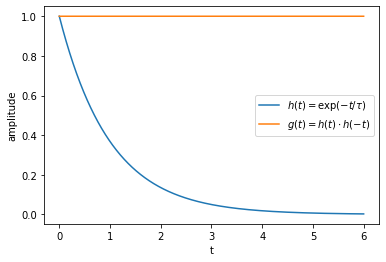

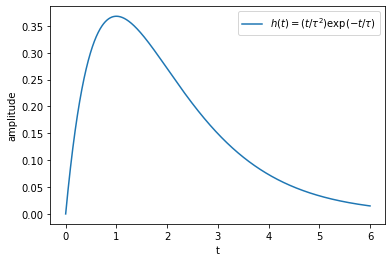

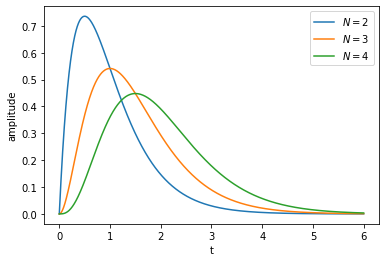

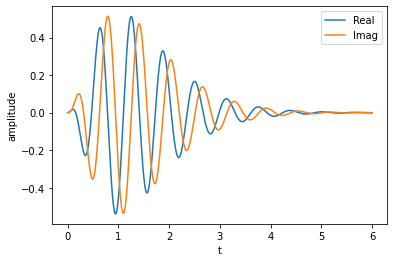

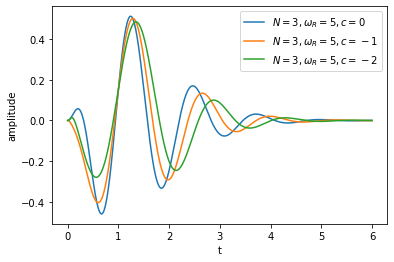

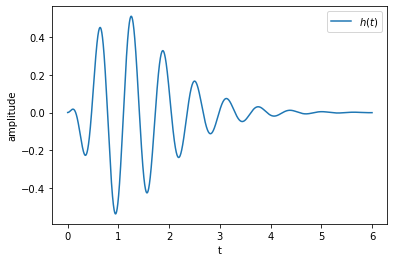

In [ ]:
# Build and save plots.

plt.plot(T, h_t, label=r'$h(t) = \exp(-t/\tau)$')
plt.plot(T, integrand, label=r'$g(t) =h(t)\cdot h(-t)$')
plt.legend()
plt.xlabel('t')
plt.ylabel('amplitude')
plt.savefig('impulse_and_integrand.png', dpi=DPI)
plt.show()

plt.plot(T, h2_t, label=r'$h(t) = (t/\tau^2)\exp(-t/\tau)$')
plt.legend()
plt.xlabel('t')
plt.ylabel('amplitude')
plt.savefig('two_coincident.png', dpi=DPI)
plt.show()

plt.plot(T, h_N(N=2, omega_r=0), label=r'$N=2$')
plt.plot(T, h_N(N=3, omega_r=0), label=r'$N=3$')
plt.plot(T, h_N(N=4, omega_r=0), label=r'$N=4$')
plt.legend()
plt.xlabel('t')
plt.ylabel('amplitude')
plt.savefig('several_gammatones', dpi=DPI)
plt.show()

plt.plot(T, h_N(N=3, omega_r=10), label='Real')
plt.plot(T, h_N(N=3, omega_r=10, is_sin=True), label='Imag')
plt.legend()
plt.xlabel('t')
plt.ylabel('amplitude')
plt.savefig('complex_gamma_imp', dpi=DPI)
plt.show()

N=3
gamma=2
omega_r=5

for c in[0, -1, -2]:
    plt.plot(T, h_gc(N=N, gamma=gamma, omega_r=omega_r, c=c), label=r'$N={}, \omega_R={}, c={}$'.format(N, omega_r, c))

plt.legend()
plt.xlabel('t')
plt.ylabel('amplitude')
plt.savefig('gammachirp', dpi=DPI)
plt.show()

plt.plot(T, h_N(N=3, omega_r=10), label=r'$h(t)$')
plt.legend()
plt.xlabel('t')
plt.ylabel('amplitude')
plt.savefig('real_gamma_imp', dpi=DPI)
plt.show()

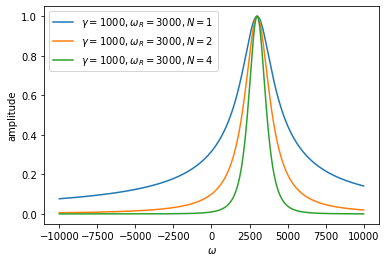

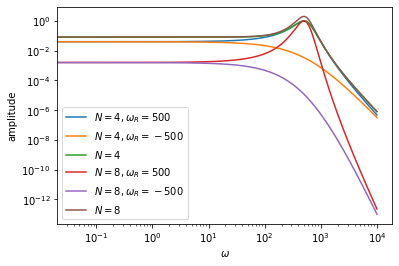

In [ ]:
W = np.linspace(-10000, 10000, SAMPLE_RATE*DUR)

gamma= 1000
omega_r = 3000
# N=3

for N in [1, 2, 4]:
    plt.plot(W, gamma_freq(N=N, omega_r=omega_r, gamma=gamma), label=r'$\gamma={}, \omega_R={}, N={}$'.format(gamma, omega_r, N))
plt.legend()
plt.xlabel(r'$\omega$')
plt.ylabel('amplitude')
plt.savefig('resonance_curve', dpi=DPI)
plt.show()

N = 3
gamma=250

both = np.zeros(DUR*SAMPLE_RATE)

for N in [4, 8]:
    for omega_r in [500, -500]:
        plt.loglog(W, gamma_freq(N=N, omega_r=omega_r, gamma=gamma), label=r'$N={}, \omega_R={}$'.format(N, omega_r))
        both += gamma_freq(N=N, omega_r=omega_r, gamma=gamma)
    plt.plot(W, both, label=r'$N = {}$'.format(N))

plt.legend()
plt.xlabel(r'$\omega$')
plt.ylabel('amplitude')
plt.savefig('low_freq_nusance', dpi=DPI)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


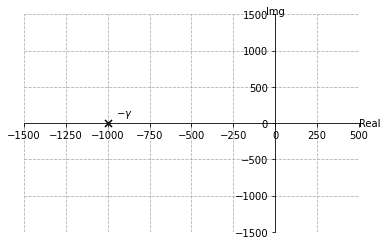

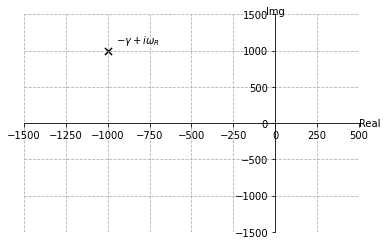

In [ ]:
plot_complex(-1000, 'neg_gamma_splane.png', label=r'$-\gamma$')
plt.show()

plot_complex(-1000 + 1000*1j, 'complex_gamma_splane.png', label=r'$-\gamma + i\omega_R$')
plt.show()